In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

sns.set(style='whitegrid', font_scale=1.5, palette='Set2')

## Проверка корректности критерия с помощью равномерности p-value

Рассмотрим выборку $X = (X_{1}, ..., X_{n}) \sim \mathcal{N}(\theta, 1)$

$\mathsf{H}_0\colon\ \theta = 0\ \ vs.\ \ \mathsf{H}_1\colon\ \theta\ > 0$

Используется одновыборочный $t$-критерий (Стьюдента).
Статистика критерия: $Z(X) = \sqrt{n}\overline{X}\ \ \stackrel{\mathsf{H}_0}{\sim}\ \ \mathcal{N}(0, 1)$. Дисперсия равна 1, а при справедливости $\mathsf{H}_0$ математическое ожидание равно нулю, поэтому дополнительные действия не требуются.

Критерий: $S = \big\{Z(x) \geqslant z_{1-\alpha}\big\}$ --- критерий, где $z_{1-\alpha}$ --- $(1-\alpha)$-квантиль $\mathcal{N}(0, 1)$.

На практике в аналитике перед применением критерием часто проверяют его на корректность следующи образом. Берут или генерируют множество выборок в предположении справедливости $\mathsf{H}_0$. По каждой из выборок вычисляется p-value, после чего по всем p-value строится гистограмма, которая визуально проверяется на равномерность.

Проверим корректность нашего критерия. Будем генерировать множество выборок размера 100.

In [2]:
sample_size = 100
sample_count = 10**6

Генерируем выборки при справедливости основной гипотезы, все в норме -- распределение равномерное.

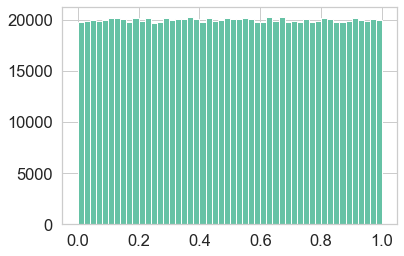

In [8]:
samples = sps.norm.rvs(size = (sample_count, sample_size))
Z_stat = np.sqrt(sample_size)*samples.mean(axis=1)
pvalues = sps.norm.sf(Z_stat)
plt.hist(pvalues, bins=50);

Как мы говорили, критерий не меняется при рассмотрении сложной основной гипотезы

$\mathsf{H}_0\colon\ \theta \leqslant 0\ \ vs.\ \ \mathsf{H}_1\colon\ \theta\ > 0$

Посмотрим, что будет при непограничном значении $\theta$ из основной гипотезы.

*Замечание.* Подобный эффект все равно не дает оснований говорить об уверенности $\mathsf{H}_0$, поскольку критерий может быть недостаточно мощным.

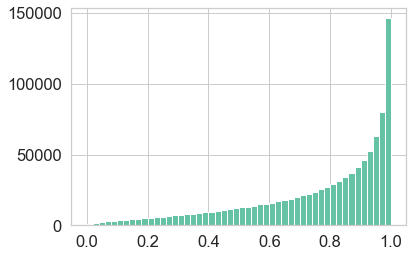

In [10]:
samples = sps.norm(loc=-.1).rvs(size = (sample_count, sample_size))
Z_stat = np.sqrt(sample_size)*samples.mean(axis=1)
pvalues = sps.norm.sf(Z_stat)

plt.hist(pvalues, bins=50);

Теперь посмотрим тоже самое при альтернативе. Как мы видим, в большинстве случаев основная гипотеза отвергается. Доля случаев, в которых p-value меньше 0.05, является оценкой мощности критерия при данном распределении из альтернативы.

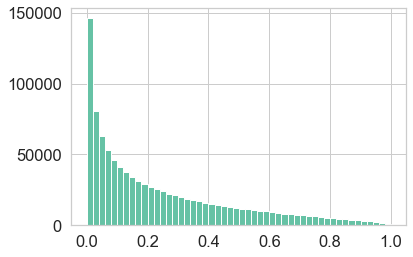

In [11]:
samples = sps.norm(loc=.1).rvs(size = (sample_count, sample_size))
Z_stat = np.sqrt(sample_size)*samples.mean(axis=1)
pvalues = sps.norm.sf(Z_stat)

plt.hist(pvalues, bins=50);

In [17]:
sns.set(font_scale=1.7, palette='Set2')

## Множественная проверка гипотез

Все процедуры реализуются простой функцией. Полная документация по ссылке.

<a href=http://statsmodels.sourceforge.net/devel/generated/statsmodels.sandbox.stats.multicomp.multipletests.html>`multipletests`</a>`
(pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)`

-----

* `pvals` --- набор p-value
* `alpha` --- контроль FWER или FDR
* `method` --- метод:
    * `bonferroni`
    * `sidak`
    * `holm-sidak`
    * `holm`
    * `fdr_bh`
    * `fdr_by`
    * другие
* `is_sorted` --- если true, то `pvals` должны быть уже отсортированы

-----

Возвращает: `reject, pvals_corrected, alphacSidak, alphacBonf`

* `reject` --- отвергаемые гипотезы
* `pvals_corrected` --- корректировка p-value. Смысл - их можно сравнивать непосредственно с `alpha`.

-----

Просто пример

In [18]:
multipletests([0.01, 0.02, 0.05, 0.07])

(array([ True, False, False, False]),
 array([0.03940399, 0.058808  , 0.0975    , 0.0975    ]),
 0.012741455098566168,
 0.0125)

Как модифицированные pvalue связаны с отклонением гипотез

In [19]:
reject, pvals_corrected = multipletests([0.016, 0.05, 0.07])[:2]
print(reject)
print(pvals_corrected)

reject, pvals_corrected = multipletests([0.017, 0.05, 0.07])[:2]
print(reject)
print(pvals_corrected)

[ True False False]
[0.0472361 0.0975    0.0975   ]
[False False False]
[0.05013791 0.0975     0.0975    ]


Далее вспомогательный код интерактивного графика чисел $\alpha_j$ для разных методов.

In [20]:
def significance_levels(m, alpha=0.05, bonferroni=True, holm=True, 
                        sidak=True, holm_sidak=True,
                        benjamini_hochberg=True, benjamini_yekutieli=True,
                        xrange=[1, None], yrange=[0, None]):
    ''' Функция, рисующая графики уровней значимости для различных методов МПГ '''
    
    if xrange[1] is None: xrange[1] = m
    if yrange[1] is None: yrange[1] = alpha
    
    range = np.arange(m) + 1
    
    plt.figure(figsize=(15, 8))
    plt.plot(range, [alpha] * m, '--', color='black')
    
    if bonferroni:
        plt.plot(range, [alpha / m] * m, lw=5, alpha=0.7, 
                 color='blue', label='bonferroni')
    if holm:
        plt.plot(range, alpha / (m-range+1), lw=5, alpha=0.7, 
                 color='red', label='holm')
    if sidak:
        plt.plot(range, [1 - (1-alpha) ** (1/m)] * m, lw=5, alpha=0.7, 
                 color='orange', label='sidak')
    if holm_sidak:
        plt.plot(range, 1 - (1-alpha) ** (1 / (m-range+1)), lw=5, alpha=0.7, 
                 color='green', label='holm_sidak')
    if benjamini_hochberg:
        plt.plot(range, range * alpha / m, lw=5, alpha=0.7, 
                 color='pink', label='benjamini_hochberg')
    if benjamini_yekutieli:
        plt.plot(range, range * alpha / (m * (1/range).sum()), 
                 lw=5, alpha=0.7, color='yellow', label='benjamini_yekutieli')
        
    plt.legend(fontsize=16)
    plt.xlim(xrange), plt.ylim(yrange)
    plt.xlabel('Порядковый номер гипотезы по возрастанию pvalue')
    plt.ylabel('Уровень значимости $\\alpha_j$')

In [21]:
xrange = widgets.FloatRangeSlider(value=[1, 10], min=1, max=10, step=1)
yrange = widgets.FloatRangeSlider(value=[0, 0.05], min=0, max=0.05, step=0.001)

# слайдер числа гипотез
m_slider = widgets.IntSlider(min=2, max=100, step=1, value=10)
# при изменении его значения обновляется слайдер xrange
def update_xrange_range(*args):
    xrange.max = m_slider.value
    xrange.value = [xrange.min, xrange.max]
m_slider.observe(update_xrange_range, 'value')

# слайдер уровня значимости
alpha_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.05)
# при изменении его значения обновляется слайдер yrange
def update_yrange_range(*args):
    yrange.max = alpha_slider.value
    yrange.value = [yrange.min, yrange.max]
alpha_slider.observe(update_yrange_range, 'value')

In [22]:
# создать виджет, но не отображать его
ip = widgets.interactive(significance_levels,
                         m=m_slider, alpha=alpha_slider,
                         bonferroni=True, holm=True, sidak=True, holm_sidak=True,
                         benjamini_hochberg=True, benjamini_yekutieli=True,
                         xrange=xrange, yrange=yrange)

# отображаем слайдеры группами
display(widgets.HBox(ip.children[:2]))
display(widgets.HBox(ip.children[2:4]))
display(widgets.HBox(ip.children[4:6]))
display(widgets.HBox(ip.children[6:8]))
display(widgets.HBox(ip.children[8:-1]))
# отображаем вывод функции
display(ip.children[-1])

ip.update()  # чтобы функция запустилась до первого изменения слайдеров

Output()

## Пример: поиск экстрасенсов

Дана бернуллиевская выборка результатов испытаний $X_1, ..., X_n \sim Bern(\theta)$

$\mathsf{H}_0\colon\ \theta = 1/2\ \ vs.\ \ \mathsf{H}_1\colon\ \theta > 1/2$

$S = \left\{\sum\limits_{i=1}^{10} x_i \geqslant c_{\alpha}\right\}$ --- критерий, где $c_{\alpha}$ --- $(1-\alpha)$-квантиль $Bin(10, 1/2)$

------

Определим критическое значение и выпишем критерий

In [24]:
alpha = 0.05
c_alpha = sps.binom(n=10, p=1/2).ppf(1-alpha)
print('Критерий: {sample_sum > %.d}' % c_alpha)

Критерий: {sample_sum > 8}


Почему в итоге знак строгий (`sf = 1 - cdf`):

In [25]:
print('%.3f, %.3f' % (sps.binom(n=10, p=0.5).sf(7.5), 
                      sps.binom(n=10, p=0.5).sf(8.5)))

0.055, 0.011


Берем 1000 человек (генерируем сразу количество верно отгаданных из биномиального распределения) и проверяем 1000 гипотез. Смотрим, во скольких случаях верную нулевую гипотезу отклоняем, то есть когда количество верно отгаданных превышает критическое значение.

In [26]:
sample = sps.bernoulli(p=1/2).rvs(size=(1000,10)).sum(axis=1)
print((sample > c_alpha).sum())

10


Для каждой гипотезы считаем pvalue. Поправка `-0.5` для того, чтобы не было проблем со строгими/нестрогими знаками. Красной линией отмечен уровень значимости $\alpha = 0.05$.

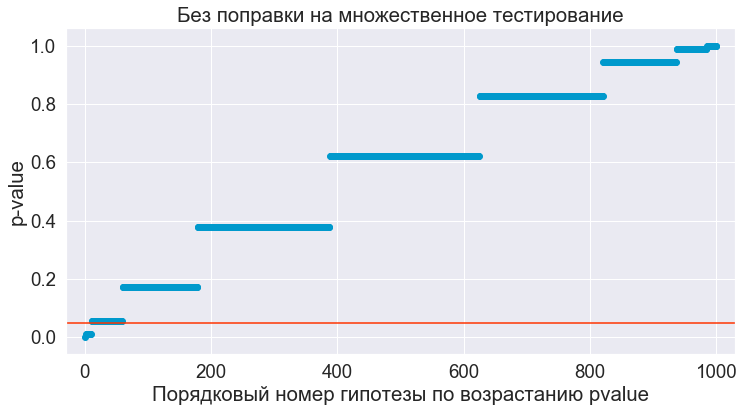

In [27]:
pvalues = sps.binom(n=10, p=1/2).sf(sample-0.5)

plt.figure(figsize=(12, 6))
plt.scatter(np.arange(1, 1001), np.sort(pvalues), color=blue)
plt.hlines(0.05, -100, 1100, color=red)
plt.xlim((-30, 1030))
plt.title('Без поправки на множественное тестирование')
plt.xlabel('Порядковый номер гипотезы по возрастанию pvalue')
plt.ylabel('p-value')
plt.show()

Применим множественную проверку гипотез методом Холма

0


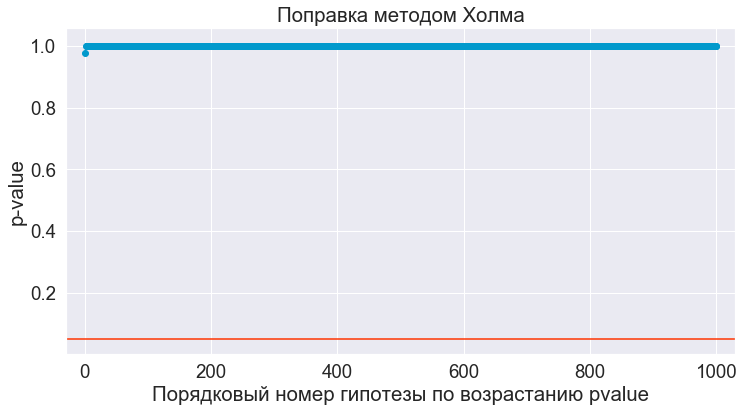

In [28]:
reject, pvals_corrected, _, _ = multipletests(pvalues, method='holm')
print(reject.sum())

plt.figure(figsize=(12, 6))
plt.scatter(np.arange(1, 1001), np.sort(pvals_corrected), color=blue)
plt.hlines(0.05, -100, 1100, color=red)
plt.xlim((-30, 1030))
plt.title('Поправка методом Холма')
plt.xlabel('Порядковый номер гипотезы по возрастанию pvalue')
plt.ylabel('p-value')
plt.show()

Теперь уже ни одна гипотеза не была отвергнута.

## Модельный эксперимент

$X_{j,1}, ..., X_{j,20} \sim \mathcal{N}(0, 1),\ \ \ \ \ j = 1,..., 150$

$X_{j,1}, ..., X_{j,20} \sim \mathcal{N}(1, 1),\ \ \ \ \ j = 151,..., 200$

$\mathsf{H}_0\colon\ \mathsf{E} X_{j,i} = 0\ \ vs.\ \ \mathsf{H}_1\colon\ \mathsf{E} X_{j,i}\ \not= 0$

Используется одновыборочный $t$-критерий (Стьюдента).

Статистика: $$T(X) = \sqrt{n-1}\frac{\overline{X}}{\sqrt{S^2}} \sim T_{n-1}\ \ \ \text{(при $H_0$)}$$

Критерий: $\big\{\left|T(X)\right| \geqslant c_{\alpha}\big\}$ --- критерий, где $c_{\alpha}$ --- $(1-\alpha/2)$-квантиль $T_{n-1}$

Генерация выборок

In [29]:
n = 100
m = 200
means = np.zeros((m, n))
means[150:] = 1
sample = sps.norm(loc=means).rvs(size=(m, n))

Изобретем велосипед, посчитав все pvalue руками. В данном случае так эффективнее, поскольку иначе при использовании готовой функции пришлось бы перебирать в цикле вызовы этой функции для каждой выборки. Здесь `t` реализует распределение Стьюдента, а `df` - число степеней свободы. Домножение на 2 поскольку критерий двусторонний.

In [31]:
T = np.sqrt(n-1)*sample.mean(axis=1)/sample.std(axis=1)
pvalues = sps.t(n-1).sf(np.abs(T)) * 2

Функция, которая рисует график rank-pvalue.

In [32]:
def draw_sorted_pvalues(pvalues, truth=None, figsize=(12, 6), title=''):
    m = len(pvalues)
    order = np.argsort(pvalues)
    pvalues = pvalues[order]
    if truth is not None:
        truth = truth[order]
    
    plt.figure(figsize=figsize)
    x = np.arange(len(pvalues))
    
    if truth is None: 
        plt.scatter(x, pvalues)
    else:
        plt.scatter(x[truth], pvalues[truth], c=blue)
        plt.scatter(x[~truth], pvalues[~truth], c=red)
        
    plt.hlines(0.05, -100, m * 1.1, color=red)
    plt.xlim((-m / 50, m * 1.05))
    plt.xlabel('Порядковый номер гипотезы по возрастанию pvalue')
    plt.ylabel('p-value')
    plt.title(title)
    plt.show()

График обычных (немодифицированных) pvalue. Синие и красные pvalue соответствуют верным и неверным нулевым гипотезам.

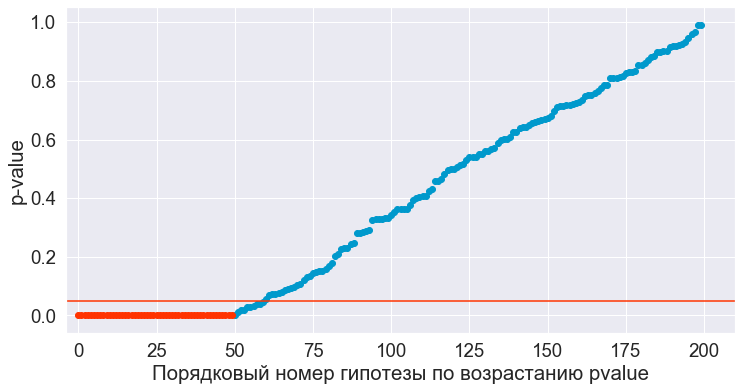

In [33]:
draw_sorted_pvalues(pvalues, truth=np.arange(200)<150)

Графики pvalue после корректировки. Все процедуры множественной проверки гипотез в данном случае применимы, поскольку все выборки независимы, соответственно независимы статистики критериев. На практике это не всегда так.

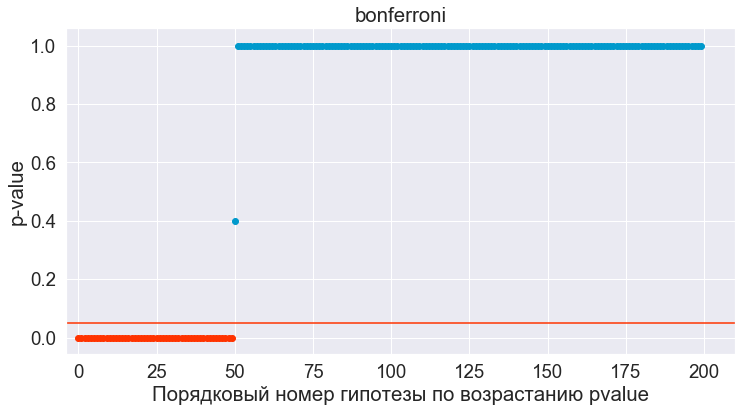

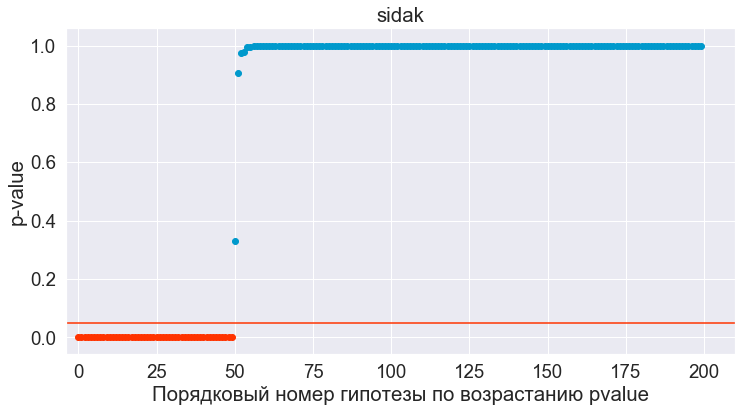

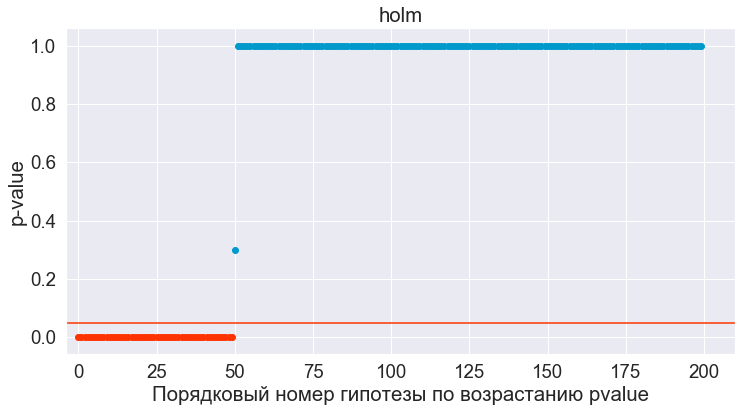

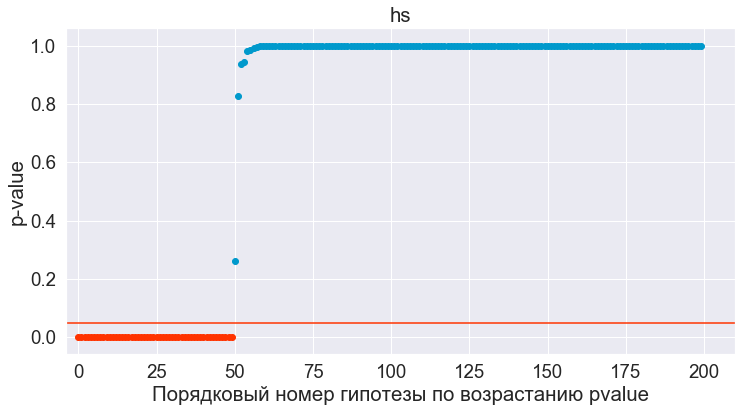

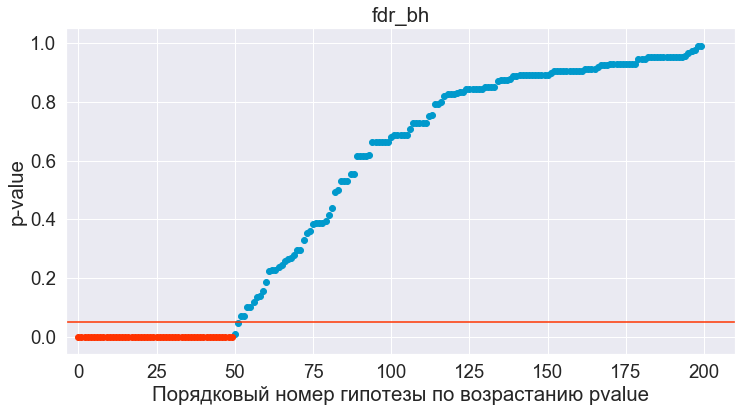

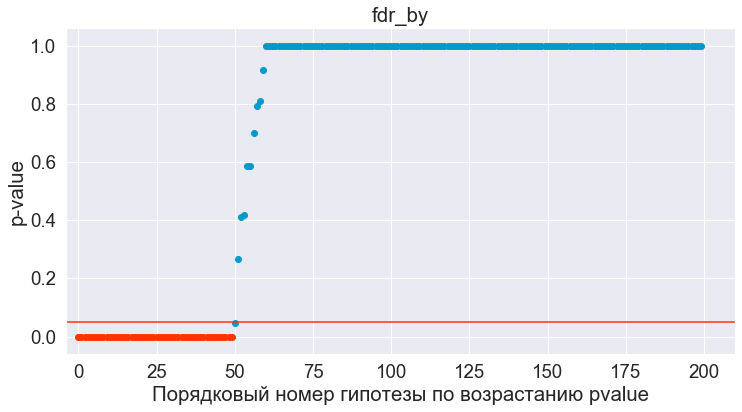

In [34]:
for method in ['bonferroni', 'sidak', 'holm', 'hs', 'fdr_bh', 'fdr_by']:
    pvals_corrected = multipletests(pvalues, method=method)[1]
    draw_sorted_pvalues(pvals_corrected, truth=np.arange(200)<150, title=method)

Методы, контролирующие FWER справились идеально.
Методы, контролирующие FDR могут отвергать некоторые верные гипотезы.

-----

Теперь подсунем такие данные:

$X_{j,1}, ..., X_{j,20} \sim \mathcal{N}(0, 1),\ \ \ \ \ j = 1,..., 100$

$X_{j,1}, ..., X_{j,20} \sim \mathcal{N}((j-100) / 100, 1),\ \ \ \ \ j = 101,..., 200$

In [35]:
n = 100
m = 200
means = np.zeros((m, n))
means[100:] = (np.arange(1, 101) / 100)[:, np.newaxis]
sample = sps.norm(loc=means).rvs(size=(m, n))

T = np.sqrt(n-1)*sample.mean(axis=1)/sample.std(axis=1)
pvalues = sps.t(n-1).sf(np.abs(T)) * 2

График pvalue до применения процедуры МПГ

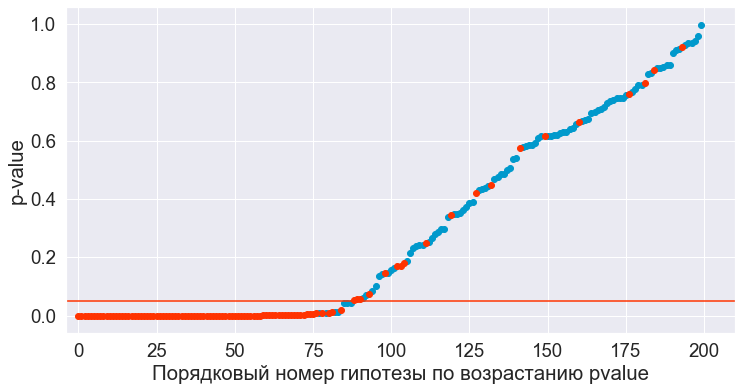

In [36]:
draw_sorted_pvalues(pvalues, truth=np.arange(200)<100)

Теперь применим методы МПГ

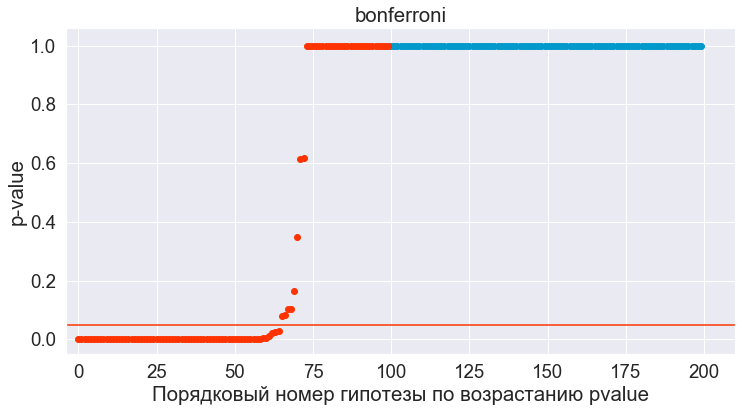

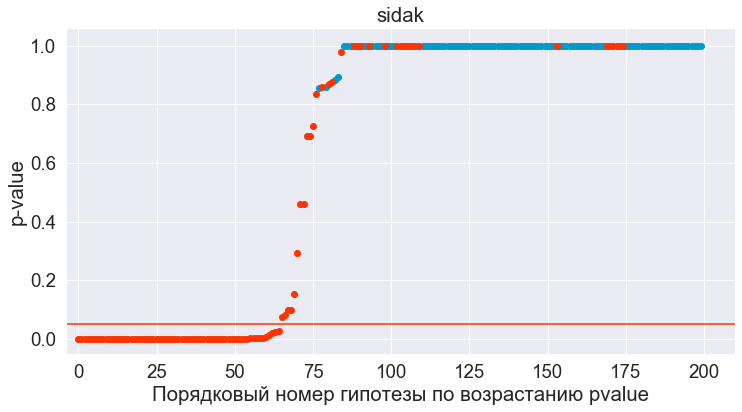

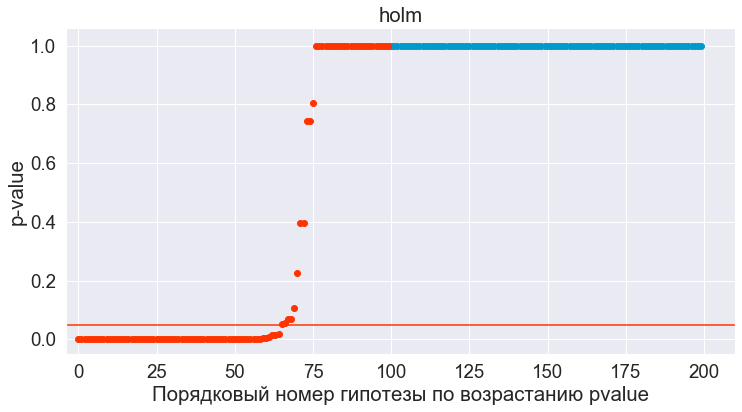

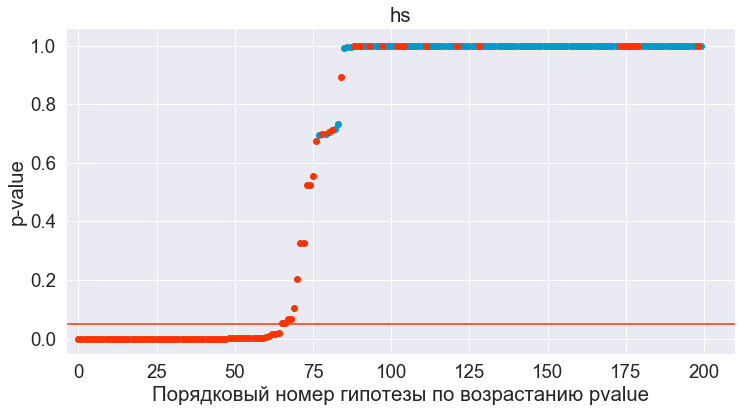

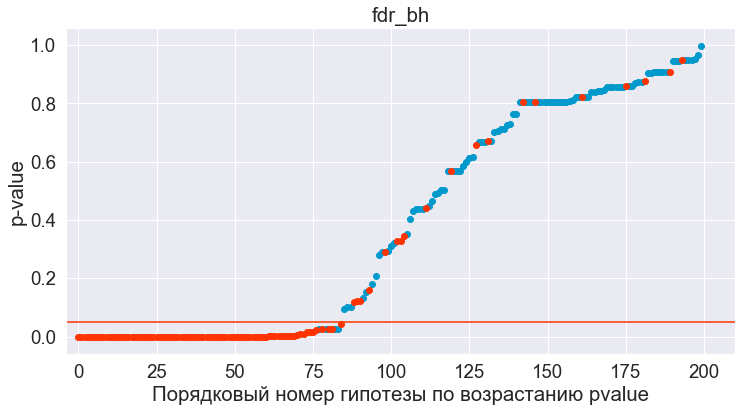

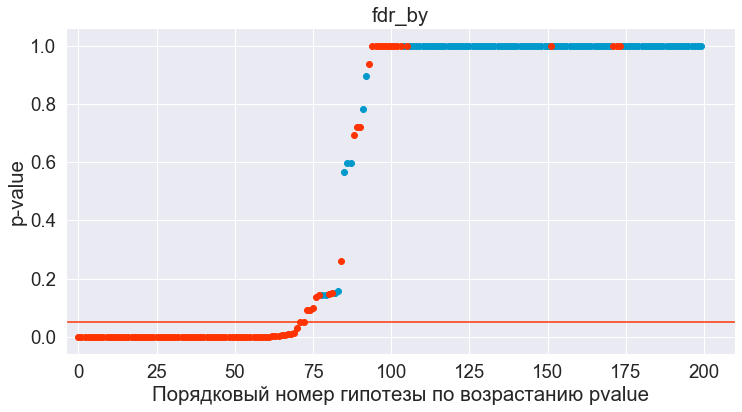

In [37]:
for method in ['bonferroni', 'sidak', 'holm', 'hs', 'fdr_bh', 'fdr_by']:
    pvals_corrected = multipletests(pvalues, method=method)[1]
    draw_sorted_pvalues(pvals_corrected, truth=np.arange(200)<100, title=method)

Более мощные методы, контролирующие FWER, отвергают несколько больше гипотез, не совершая при этом ошибок первого рода.
Методы, контролирующие FDR, отвергают больше гипотез, но среди них могут быть верные гипотезы.

# Итог

Какой подход использовать?

* При первичном анализе данных, при котором только происходит формулировка интересных гипотез, можно вообще не делать поправки на МПГ. При этом **всегда** нужно приводить информацию об общем количестве гипотез и количестве отвергнутых.
* При проведении исследований и отбора признаков для дальнейшего анализа, который обычно является более сложным и дорогим, следует применять методы, контролирующие **FDR**. Обычно берут $FDR \leqslant 0.1$.
* На этапе подтверждения выводов следует проводить строгий контроль за вероятностью ошибок первого рода, контролируя **FWER**. Обычно берут $FWER \leqslant 0.05$.

Взаимосвязь процедур:

* Методы Бонферрони (FWER), Холма (FWER), Бенджамини-Иекутиели (FDR) универсальны -- не зависят от взаимосвязей между статистиками.
* Все рассмотренные методы применимы для независимых статистик.
* Метод Холма (FWER) всегда мощнее метода Бонферрони (FWER).
* Метод Шидака-Холма (FWER) всегда мощнее метода Шидака (FWER).
* Методы Шидака (FWER) и Шидака-Холма (FWER), требующие независимость (или чуть слабее), несущетвенно мощнее универсмальных методов Бонферрони (FWER) и Холма (FWER) соответственно.
* Метод Бенджамини-Хохберга (FDR), требующий независимость (или чуть слабее), существенно мощнее универсального метода Бенджамини-Иекутиели (FDR).
* Если доля неверных гипотез мала, то метод Холма (FWER) не сильно мощнее метода Бонферрони (FWER).
* Если доля неверных гипотез мала, то метод Бенджамини-Иекутиели (FDR) отвергает меньше гипотез, чем метод Холма (FWER).
* Если гипотез мало, метод Бенджамини-Иекутиели (FDR) отвергает меньше гипотез, чем метод Холма (FWER).

--------

<a href="http://www.myshared.ru/slide/398736/"><img src='https://pp.userapi.com/c841232/v841232300/79b18/-UCkrnG05DQ.jpg'/></a>